# Assignment 4 CS 5316 Natural Language Processing

In [5]:
%matplotlib inline
import numpy as np
from IPython.display import Image
# Get the interactive Tools for Matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from nltk import ngrams
import pandas as pd
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, RepeatVector,Flatten, TimeDistributed, Input,Bidirectional,LocallyConnected1D,Conv1D,GlobalAveragePooling1D,GlobalMaxPooling1D,Concatenate,BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM ,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
# import tensorflow.keras.utils.to_categorical as to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.model_selection import train_test_split as splitter
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Final Assignment
This is going to be the final assignment for deep learning. Here is a very good visual for what you will be doing with
<a href="https://ibb.co/mh9Ks0j">deep learning.</a> Lets get started.......

# TASK 1 Paraphrase Detection
For this task we will be using the [ Microsoft Research Paraphrase Corpus ](https://www.microsoft.com/en-us/download/details.aspx?id=52398). The corpus consist of sentence pairs with 1 or 0 labels which identify if the sentences are paraphrase or not respectively.
<br>
To perform this task we will be using recurrent neural network for this task specifically the [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). RNN can be architected in multiple ways. Some of the possible ways are as follows:
<img src="archetecturernn.png">
The box in the bottom is the input, followed by the hidden layer (as the middle box), and the box on top is the output layer. The one-to-one architecture is the typical neural network (<i>vanila/Feed Forward</i>) with a hidden layer between the input and the output layer. Example uses of the above archetecture are as follows:
<ul>
    <li>One-to-many: input is an image and outputs are image captions</li>
    <li>Many-to-one: input is a movie's review <i>multiple words in input</i> and output is sentiment associated with the review <i>(we will be using a similar archetecture for our purpose)</i></li>
    <li>Many-to-many: machine translation of a sentence in one language to a sentence in another language, POS tagging etc</li>
</ul>
<br>
For this task we will also be using pre-trained word embeddings specificallly <a href="https://nlp.stanford.edu/projects/glove/">(GloVe Embeddings)</a>. Please download the paraphrase <a href="https://www.microsoft.com/en-us/download/details.aspx?id=52398">dataset</a> and glove.6B.zip from <a href="https://nlp.stanford.edu/projects/glove/">here</a>.

For this task you are required to implement the following archetecture, please use [keras functional API](https://www.tensorflow.org/guide/keras/functional) :
<img src="paraphrase.png">
If <a href="https://ibb.co/RSSjRM0">this</a> is you reaction after seeing the model archetecture dont worry we'll explain.
The model works as follows, there will be two inputs layers, one for each sentence followed by <b>shared</b> embedding layer which feed thier outputs to the shared LSTM, <b>take the final hidden state output</b> of both LSTM's and concatenate them. Finally feed the concatenated vector to a softmax output layer for classification.
<br>
<i>(The reason for using one shared embedding and LSTM layer so that the model learns sentence representation for all sentence pairs(x,x') in the dataset. If we were using two seperate LSTMS for x and x' we would need to double the dataset by having both (x,x') and (x',x) pairs so that both LSTM's see the entire train data distribution)</i>
The purpose for each layer in the model is as follows:
<ul>
    <li>Input takes the input sequences and feeds it to the next(you will need to specify the maximum size of a sentence as a parameter of this layer)</li>
    <li>Embedding layer, this layer takes the sequence input then for each word in the sequence generates a fixed size vector <i>(word embedding)</i>, this layer can be trained from scratch or can be configured to use pretrained embeddings with or without fine tuning. </li>
    <li>LSTM process the embedding vector sequences and at each step generates a hidden state vector(h)and cell memory vector(C)(<i>see diagram</i>), the keras LSTM layer returns three outputs (1) All the hidden states,(2) The final hidden state and (3) The final cell memory state<img src="lstm.png"></li>
    <li>The concatenation layer combines multple vectors into a single vector</li>
    <li>Finally the output layer predicts if sentence pairs were paraphrase or not</li>
</ul>
<b>Please refer to the TF-keras documentation for all the layers <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers">here</a></b>
<br><br><br>
Now that you understand the theoritical foundation for our approach lets move onto practical implementation.<br>
<h3>Data Preperation</h3>

<ul>
    <li> First we need to preprocess the data, convert the data to lower casing. Any other preprocessing procedures are optional but keep in mind that this will affect the performance of your model.</li>
    <li> To make training faster we will fix the maximum sequence length to 20 truncate the longer sequences.</li>
    <li> Split the data into test, train and validation in the ratio 20,70,10. Use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">scikit_test_train_split</a> <br><i><b>Hint:</b> use the splitter twice to get desired data splits.</i></li>
    <li> Next we need the vocabulary, vocabulary size and to convert sentences to numeric sequences by representing each word with a numeric value which will make our implementation easier later on, use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">Tokenizer</a> from keras. <br><i>(Fit the tokenizer on train data and use the same tokenizer to convert train,test and validation data to numeric sequences)</i> </li>
    <li>  Use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences"> pad sequences</a> to add post padding to all sentences that are shorter than maximum sequence length
        <i>(<b>extra info</b>: fit_on_text reserves value/index 0 for padding and assigns numeric value to words starting from index 1)</i></li>
</ul>
<h3>Loading embeddings</h3>
<ul>
    <li> To use pretrained embeddings in tf keras embedding layer requires a dictionary, we need to create a dictionary whose keys will be numeric word representations and values will be the embedding vectors.</li>
    <li> First step is to load the word embedding pairs from the glove file into a dictionary.</li>
    <li> Next we will create a dictionary for our dataset's vocabulary. Copy all the word embeddings for words that are in our vocabulary and in the glove dictionary, if a word exists in our vocabulary but does not exist in glove dictionary create a zero vector of embedding dimension size and add it to the dictionary.</li>
</ul>
<h3>Create Model</h3>
<ul>
    <li> Create the model using <a href"https://www.tensorflow.org/guide/keras/functional">functional API</a></li>
    <li> Hints: The emebedding layer has a parameter that allows you to use pretrained embeddings, for shared layers read the section of shared layer weights in function API docs</li>

In [6]:
def loadData():
    """
    Return preprocessed data
    
    Returns: X and Y where X is pair of sentence (x,x') and y is the label 0 or 1
    """
    pairs=[]
    data=pd.read_table("/content/drive/My Drive/Colab Notebooks/Assignment4/msr_paraphrase_train.txt",error_bad_lines=False)
    X1=data['#1 String'].str.lower()
    X2=data['#2 String'].str.lower()
    labels=data['Quality']
    X1=list(X1)
    X2=list(X2)
    labels=list(labels)
    
    
    
    return X1,X2,labels

X1,X2,labels=loadData()





b'Skipping line 102: expected 5 fields, saw 6\nSkipping line 656: expected 5 fields, saw 6\nSkipping line 867: expected 5 fields, saw 6\nSkipping line 880: expected 5 fields, saw 6\nSkipping line 980: expected 5 fields, saw 6\nSkipping line 1439: expected 5 fields, saw 6\nSkipping line 1473: expected 5 fields, saw 6\nSkipping line 1822: expected 5 fields, saw 6\nSkipping line 1952: expected 5 fields, saw 6\nSkipping line 2009: expected 5 fields, saw 6\nSkipping line 2230: expected 5 fields, saw 6\nSkipping line 2506: expected 5 fields, saw 6\nSkipping line 2523: expected 5 fields, saw 6\nSkipping line 2809: expected 5 fields, saw 6\nSkipping line 2887: expected 5 fields, saw 6\nSkipping line 2920: expected 5 fields, saw 6\nSkipping line 2944: expected 5 fields, saw 6\nSkipping line 3241: expected 5 fields, saw 6\nSkipping line 3358: expected 5 fields, saw 6\nSkipping line 3459: expected 5 fields, saw 6\nSkipping line 3491: expected 5 fields, saw 6\nSkipping line 3643: expected 5 fields

In [0]:
def preprocessing(data):
    """
    Return preprocessed data

    Args:
        data : sentence pairs
    
    Returns: preprocessed_data
    preprocessed_data : preprocessed dataset 
    """
    #keeping alphabets and numbers only 
    for i in range(0,len(data)):
      data[i]=" ".join((re.findall('[a-z0-9]+',str(data[i]))))
    
    #removing stop words and len(w) == 1
    stop_w=set(stopwords.words('english'))
    for i in range(0,len(data)):
      tokenized=data[i].split(" ")
      filtered=[k for k in tokenized if k not in stop_w and len(k) > 1 ]
      data[i]=" ".join(filtered)

    #Truncating
    for i in range(0,len(data)):
      tokenized=data[i].split(" ")
      if len(tokenized) > 20:
        data[i]=" ".join(tokenized[:20])

    return data
X1=preprocessing(X1)
X2=preprocessing(X2)

In [0]:
def makepairs(X1,X2):
  pairs=[]
  for i in range(0,len(X1)):
    pairs.append((X1[i],X2[i]))
  return pairs
data = makepairs(X1,X2)

### Test train split
Use test train split from sklearn.


In [0]:
def testTrainSplit(data_X,data_Y):
    """
    Return test train data

    Args:
        data_X : sentence pairs
        data_Y: labels
        
    Returns: test train and validation split data 
    """
    train_data,valid_data,train_labels,valid_labels=splitter(data_X,data_Y,train_size=0.9,test_size=0.1,shuffle=True)
    train_data,test_data,train_labels,test_labels=splitter(train_data,train_labels,train_size=0.8,test_size=0.2,shuffle=True)

    return train_data,train_labels,test_data,test_labels,valid_data,valid_labels

train_data,train_labels,test_data,test_labels,valid_data,valid_labels=testTrainSplit(data,labels)


Implement the step regarding keras Tokenizer in the cell below.<br>
<i> Keep in mind that each example is a pair/tupple of sentence(x,x'), combine them into a single sentence so that your data is a list of sentences before calling fit on text(Tokenizer). There is out of vocabulary option in tokenizer check that out aswell.</i>

In [0]:
# Get vocabulary, vocabulary size and numeric word seqeunces for train,test and validation data

def stacker(data):
  data1=[]
  for i in range(0,len(data)):
    data1.append(data[i][0] +" " + data[i][1])
  return data1


def getvocab(data):
  tokenizer=Tokenizer(split=' ',oov_token="UNK")
  tokenizer.fit_on_texts(data)
  vocab = list(tokenizer.word_index.keys())
  vocab_size = len(vocab)
  return tokenizer,vocab,vocab_size

def text2sec(tokenizer,data):
  X1=[]
  X2=[]
  #detupling
  for i in data:
    X1.append(i[0])
    X2.append(i[1])
  #generating numbers
  X1=tokenizer.texts_to_sequences(X1)
  X2=tokenizer.texts_to_sequences(X2)
  #padding
  X1=pad_sequences(X1,padding="post",maxlen=20)
  X2=pad_sequences(X2,padding='post',maxlen=20)

  

  return X1,X2

  


stacked_train = stacker(train_data)
tokenizer,vocab,vocab_size=getvocab(stacked_train)
X1,X2=text2sec(tokenizer,train_data)
V1,V2=text2sec(tokenizer,valid_data)
T1,T2=text2sec(tokenizer,test_data)





In [0]:
def one_hot(labels):
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(labels)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded= onehot_encoder.fit_transform(integer_encoded)
  return np.array(onehot_encoded)

train_labels = one_hot(train_labels)
test_labels = one_hot(test_labels)
valid_labels = one_hot(valid_labels)


In [0]:
#loading embeddings
#50d
path = 'glove.6B.100d.txt'
with open(path,'r')as f:
  lines=f.readlines()
  f.close()
d_50={}
for i in lines:
  line=i.split(" ")
  word=line[0]
  d_50[word]=[float(j) for j in line[1:]]
#adding 0
d_50['UNK']=np.zeros(100,dtype='float')

    

In [0]:
Emb_dim=100
def embed(dict,vocab):
  Emb_dim=100
  emb_matrix = np.zeros((len(vocab)+1,Emb_dim))
  for index,i in enumerate(vocab):
      if i in list(d_50.keys()):
          emb_matrix[index]=d_50[i]
  return emb_matrix

d_50_embeddings =embed(d_50,vocab) 

Create the model in the cell below:
Try out different sizes for LSTM 50,100,300 and use relu activations. Also report results with Bi-LSTM as well.<br>
<i>To boost performance you can try adding a hidden layer between the lstm and output layer and also by adding a dropout layer in between different layers</i>

# **BILSTM**



In [14]:
# code model here

input_layer1=Input(shape=(20,))
input_layer2=Input(shape=(20,))
emb=Embedding(vocab_size+1,Emb_dim,weights=[d_50_embeddings],input_length=20,trainable=False)
first_emb = emb(input_layer1)
second_emb = emb(input_layer2)
lstm=Bidirectional(LSTM(100,return_state=False,return_sequences=False))
out1 = lstm(first_emb)
out2=lstm(second_emb)
concat = Concatenate()([out1,out2])
output=Dense(2,activation='softmax')(concat)

model1 = Model(inputs=[input_layer1,input_layer2], outputs=[output])
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model1.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 100)      1066100     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200)          160800      embedding[0][0]              

# **LSTM**

In [15]:
input_layer1=Input(shape=(20,))
input_layer2=Input(shape=(20,))
emb=Embedding(vocab_size+1,Emb_dim,weights=[d_50_embeddings],input_length=20,trainable=False)
first_emb = emb(input_layer1)
second_emb = emb(input_layer2)
lstm=LSTM(100,return_state=True,return_sequences=True)
_,out1,_ = lstm(first_emb)
_,out2,_=lstm(second_emb)
concat = Concatenate()([out1,out2])
output=Dense(2,activation='softmax')(concat)

model2 = Model(inputs=[input_layer1,input_layer2], outputs=[output])
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model2.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 100)      1066100     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 20, 100), (N 80400       embedding_1[0][0]          

In [0]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model1" + ".hdf5"
logfilepath = "setting_"+"model1" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=10,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]



In [17]:
model1.fit([np.array(X1),np.array(X2)],train_labels, epochs=100, batch_size=32,validation_data=(([V1,V2], valid_labels)),verbose=1,shuffle=True,callbacks=callbacks_list)

Epoch 1/100
89/89 [==============================] - 3s 30ms/step - loss: 0.6240 - categorical_accuracy: 0.6762 - val_loss: 0.6123 - val_categorical_accuracy: 0.6751 - lr: 0.0010
Epoch 2/100
89/89 [==============================] - 1s 11ms/step - loss: 0.5912 - categorical_accuracy: 0.6907 - val_loss: 0.6593 - val_categorical_accuracy: 0.5990 - lr: 0.0010
Epoch 3/100
89/89 [==============================] - 1s 11ms/step - loss: 0.5627 - categorical_accuracy: 0.7037 - val_loss: 0.6134 - val_categorical_accuracy: 0.6802 - lr: 0.0010
Epoch 4/100
89/89 [==============================] - 1s 11ms/step - loss: 0.5233 - categorical_accuracy: 0.7351 - val_loss: 0.6528 - val_categorical_accuracy: 0.6904 - lr: 0.0010
Epoch 5/100
89/89 [==============================] - 1s 11ms/step - loss: 0.4705 - categorical_accuracy: 0.7781 - val_loss: 0.7045 - val_categorical_accuracy: 0.6447 - lr: 0.0010
Epoch 6/100
89/89 [==============================] - 1s 11ms/step - loss: 0.4160 - categorical_accuracy: 

In [18]:
model2.fit([np.array(X1),np.array(X2)],train_labels, epochs=100, batch_size=32,validation_data=(([V1,V2], valid_labels)),verbose=1,shuffle=True,callbacks=callbacks_list)

Epoch 1/100
89/89 [==============================] - 1s 13ms/step - loss: 0.6292 - categorical_accuracy: 0.6737 - val_loss: 0.6229 - val_categorical_accuracy: 0.6802 - lr: 0.0010
Epoch 2/100
89/89 [==============================] - 1s 6ms/step - loss: 0.6056 - categorical_accuracy: 0.6847 - val_loss: 0.6481 - val_categorical_accuracy: 0.6244 - lr: 0.0010
Epoch 3/100
89/89 [==============================] - 1s 6ms/step - loss: 0.5966 - categorical_accuracy: 0.6829 - val_loss: 0.6190 - val_categorical_accuracy: 0.6802 - lr: 0.0010
Epoch 4/100
89/89 [==============================] - 1s 6ms/step - loss: 0.5706 - categorical_accuracy: 0.7108 - val_loss: 0.6544 - val_categorical_accuracy: 0.6142 - lr: 0.0010
Epoch 5/100
89/89 [==============================] - 1s 6ms/step - loss: 0.5533 - categorical_accuracy: 0.7231 - val_loss: 0.6450 - val_categorical_accuracy: 0.6396 - lr: 0.0010
Epoch 6/100
89/89 [==============================] - 1s 6ms/step - loss: 0.5178 - categorical_accuracy: 0.746

Use the <b>model.predict</b> method to get predictions. There predictions will be a probability distribution over the lables, to get the desired class take the max value in a prediction vector as the predicted class.<br>

# **LSTM**



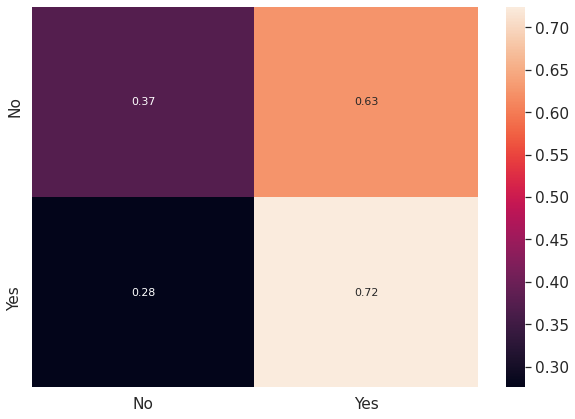

In [19]:
#predictions = code here
labelList=["No","Yes"]
predictions = model2.predict([T1,T2])

pred=[]
for i in predictions:
    pred.append(np.argmax(i))
predictions=pred

from sklearn.metrics import confusion_matrix

test_Y_max=np.argmax(test_labels, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()

In [20]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = labelList))

Classification Report
               precision    recall  f1-score   support

          No       0.39      0.37      0.38       227
         Yes       0.71      0.72      0.72       482

    accuracy                           0.61       709
   macro avg       0.55      0.55      0.55       709
weighted avg       0.61      0.61      0.61       709



# **BILSTM**

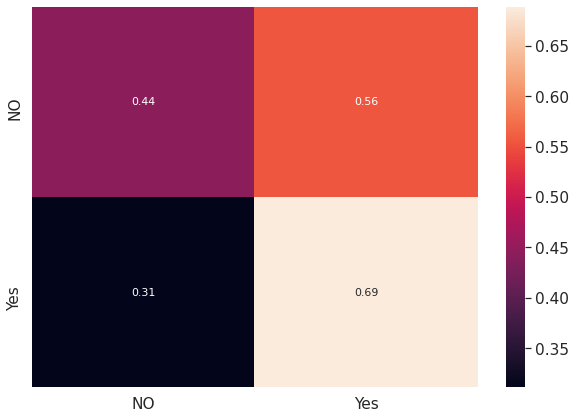

In [21]:
#predictions = code here
labelList=["NO","Yes"]
predictions = model1.predict([T1,T2])

pred=[]
for i in predictions:
    pred.append(np.argmax(i))
predictions=pred

from sklearn.metrics import confusion_matrix

test_Y_max=np.argmax(test_labels, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()

In [22]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = labelList))

Classification Report
               precision    recall  f1-score   support

          NO       0.40      0.44      0.42       227
         Yes       0.72      0.69      0.71       482

    accuracy                           0.61       709
   macro avg       0.56      0.57      0.56       709
weighted avg       0.62      0.61      0.62       709



# Task 2 Sentiment Classification
For this task we will be reusing the movie reviews dataset available on <a href="https://www.kaggle.com/c/word2vec-nlp-tutorial/data">kaggle</a> and download the dataset from there. 
We will be using the unlabeledTrainData file and labeledTrainData file. We will use the gensim package to train word2vec embeddings using [gensim](https://radimrehurek.com/gensim/) package and unlabelled train data as in the previous assignmnet. Now instead for creating a single representation for each review we will be using deep learning models for this task. We will use the same archetecture as before but will experiment with different reccurant networks namely RNN, GRU and LSTM.<br> This task might feel like <a href="https://ibb.co/Tgh2XyH">this</a> but since this is a deep learning assignment thus we must use it.
<h3>Data Preperation</h3>
<ul>
    <li> First we need to preprocess the data, convert the data to lower casing(both files). Any other preprocessing procedures are optional but keep in mind that this will affect the performance of your model.</li>
    <li> Split the labeledTrainData data file into test, train and validation in the ratio 20,70,10. Use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">scikit_test_train_split</a> <br><i><b>Hint:</b> use the splitter twice to get desired data splits.</i></li>
    <li> Next we need the vocabulary, vocabulary size and to convert sentences to numeric sequences by representing each word with a numeric value which will make our implementation easier later on, use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">Tokenizer</a> from keras. <br><i>(Fit the tokenizer on train data and use the same tokenizer to convert train,test and validation data to numeric sequences)</i> </li>
    <li>  Use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences"> pad sequences</a> to add post padding to all sentences that are shorter than maximum sequence length</li>
    <li> Use one hot representation for targets/labels, you can use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">scikit learn</a> or <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing">keras preprocessing</a>.</li>
</ul>
<h3>Loading embeddings</h3>
<ul>
    <li> As state before use the gensim package to train the word2vec model on unlabelledTrainData file</li>
    <li> Next we will create a dictionary for our dataset's vocabulary. Copy all the word embeddings for words that are in our vocabulary and in the word2vec model, if a word exists in our vocabulary but does not exist in word2vec model create a zero vector of embedding dimension size and add it to the dictionary.</li>
</ul>
<h3>Create Model</h3>
<ul>
    <li> Here is a visual for the model <img src="sentimentdeep.png">
    <li> Create the model using <a href"https://www.tensorflow.org/guide/keras/functional">functional API</a> or the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential">Sequential API</a></li>
    <li> Hints: The emebedding layer has a parameter that allows you to use pretrained embeddings</li>



Use can reuse the code snippets from above for call backs, prediction heat map and classification report
<i>You will have provide a label list for this specific dataset inorder for them to run, you are to make the required changes yourself</i>

In [7]:
#loading data 
import pandas as pd
unlabeled=pd.read_table('unlabeledTrainData.tsv',sep="\t",error_bad_lines=False,encoding='utf-8')
unlabeled=list(unlabeled['review'].str.lower())
labeled=pd.read_csv('labeledTrainData.tsv',sep='\t',encoding='utf-8')
labels = list(labeled['sentiment'])
data  = (labeled['review'].str.lower())



b'Skipping line 43043: expected 2 fields, saw 3\n'


In [0]:
def preprocessing(data):
    """
    Return preprocessed data

    Args:
        data : sentence pairs
    
    Returns: preprocessed_data
    preprocessed_data : preprocessed dataset 
    """
    #keeping alphabets and numbers only 
    for i in range(0,len(data)):
      data[i]=" ".join((re.findall('[a-z0-9]+',str(data[i]))))
    
    #removing stop words and len(w) == 2
    stop_w=set(stopwords.words('english'))
    for i in range(0,len(data)):
      tokenized=data[i].split(" ")
      filtered=[k for k in tokenized if k not in stop_w and len(k) > 2 ]
      data[i]=" ".join(filtered)

    #Truncating
    for i in range(0,len(data)):
      tokenized=data[i].split(" ")
      if len(tokenized) > 20:
        data[i]=" ".join(tokenized[:20])

    return data

unlabel_data = preprocessing(unlabeled)
label_data   = preprocessing(data)

In [0]:
for i in range(0,len(unlabel_data)):
  unlabel_data[i]=unlabel_data[i].split(" ")
for j in range(0,len(label_data)):
  label_data[j]=label_data[j].split(" ")

In [10]:

from gensim.models import Word2Vec
def word2vec(data):
  path = get_tmpfile("word2vec.model")
  model = Word2Vec(data, size=100, window=5, min_count=1, workers=4)
  model.save("word2vec.model")
  return model

wordvec=word2vec(unlabel_data)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
copy1=unlabel_data
def getvocab(data):
  tokenizer=Tokenizer(oov_token="UNK")
  tokenizer.fit_on_texts(data)
  vocab = list(tokenizer.word_index.keys())
  vocab_size = len(vocab)
  return tokenizer,vocab,vocab_size

def text2sec(tokenizer,data):

  #generating numbers
  seq=tokenizer.texts_to_sequences(data)
  #padding
  seq=pad_sequences(seq,padding="post",maxlen=30)

  return seq
tokenizer,vocab,vocab_size=getvocab(copy1)
unlabel_data=text2sec(tokenizer,unlabel_data)
label_data=text2sec(tokenizer,label_data)



In [0]:
def testTrainSplit(data_X,data_Y):
    """
    Return test train data

    Args:
        data_X : sentence pairs
        data_Y: labels
        
    Returns: test train and validation split data 
    """
    train_data,valid_data,train_labels,valid_labels=splitter(data_X,data_Y,train_size=0.9,test_size=0.1,shuffle=True)
    train_data,test_data,train_labels,test_labels=splitter(train_data,train_labels,train_size=0.8,test_size=0.2,shuffle=True)

    return train_data,train_labels,test_data,test_labels,valid_data,valid_labels

train_data,train_labels,test_data,test_labels,valid_data,valid_labels=testTrainSplit(label_data,labels)

In [13]:
def embed(model,vocab):
  Emb_dim=100
  emb_matrix = np.zeros((len(vocab)+1,Emb_dim))
  for index,i in enumerate(vocab):
      try:
        emb_matrix[index]=model[i]
      except:
        continue
  return emb_matrix

d_100_embeddings =embed(wordvec,vocab) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
def one_hot(labels):
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(labels)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded= onehot_encoder.fit_transform(integer_encoded)
  return np.array(onehot_encoded)

train_Labels=one_hot(train_labels)
test_Labels=one_hot(test_labels)
valid_Labels=one_hot(valid_labels)


#**GRU**

In [15]:
import tensorflow as tf
Emb_dim=100
input_layer=Input(shape=(30,))
emb=Embedding(vocab_size+1,Emb_dim,weights=[d_100_embeddings],input_length=30,trainable=False)
emb_out=emb(input_layer)
GRU=tf.keras.layers.GRU(100)
out = GRU(emb_out)
hidden = Dense(50,activation='relu')
out_hidden=hidden(out)
output=Dense(2,activation='softmax')(out_hidden)

model3 = Model(inputs=[input_layer], outputs=[output])
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 100)           4470800   
_________________________________________________________________
gru (GRU)                    (None, 100)               60600     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 4,536,552
Trainable params: 65,752
Non-trainable params: 4,470,800
_________________________________________________________________


#**LSTM**

In [16]:
import tensorflow as tf
Emb_dim=100
input_layer=Input(shape=(30,))
emb=Embedding(vocab_size+1,Emb_dim,weights=[d_100_embeddings],input_length=30,trainable=False)
emb_out=emb(input_layer)
lstm=tf.keras.layers.LSTM(100,return_sequences=True,return_state=True)
_,out,_ = lstm(emb_out)
output=Dense(2,activation='softmax')(out)

model4 = Model(inputs=[input_layer], outputs=[output])
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model4.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 100)           4470800   
_________________________________________________________________
lstm (LSTM)                  [(None, 30, 100), (None,  80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 4,551,402
Trainable params: 80,602
Non-trainable params: 4,470,800
_________________________________________________________________


In [17]:
model3.fit(np.array(train_data),np.array(train_Labels), epochs=20, batch_size=32,verbose=1,validation_data=(np.array(valid_data),np.array(valid_Labels)),shuffle=True,callbacks=callbacks_list)

Epoch 1/20
563/563 [==============================] - 3s 5ms/step - loss: 0.6933 - categorical_accuracy: 0.4981 - val_loss: 0.6933 - val_categorical_accuracy: 0.4932 - lr: 0.0010
Epoch 2/20
563/563 [==============================] - 2s 4ms/step - loss: 0.6932 - categorical_accuracy: 0.4996 - val_loss: 0.6931 - val_categorical_accuracy: 0.5068 - lr: 0.0010
Epoch 3/20
563/563 [==============================] - 2s 4ms/step - loss: 0.6932 - categorical_accuracy: 0.5001 - val_loss: 0.6932 - val_categorical_accuracy: 0.4932 - lr: 0.0010
Epoch 4/20
563/563 [==============================] - 2s 4ms/step - loss: 0.6932 - categorical_accuracy: 0.4990 - val_loss: 0.6934 - val_categorical_accuracy: 0.4932 - lr: 0.0010
Epoch 5/20
563/563 [==============================] - 2s 4ms/step - loss: 0.6932 - categorical_accuracy: 0.4986 - val_loss: 0.6933 - val_categorical_accuracy: 0.4932 - lr: 0.0010
Epoch 6/20
563/563 [==============================] - 2s 4ms/step - loss: 0.6932 - categorical_accuracy: 

In [18]:
model4.fit(train_data,train_Labels, epochs=20, batch_size=32,verbose=1,shuffle=True,callbacks=callbacks_list,validation_data=(np.array(valid_data),np.array(valid_Labels)))

Epoch 1/20
563/563 [==============================] - 3s 5ms/step - loss: 0.6930 - categorical_accuracy: 0.5129 - val_loss: 0.6873 - val_categorical_accuracy: 0.5580 - lr: 0.0010
Epoch 2/20
563/563 [==============================] - 3s 5ms/step - loss: 0.6672 - categorical_accuracy: 0.5837 - val_loss: 0.6291 - val_categorical_accuracy: 0.6324 - lr: 0.0010
Epoch 3/20
563/563 [==============================] - 3s 4ms/step - loss: 0.6285 - categorical_accuracy: 0.6339 - val_loss: 0.6179 - val_categorical_accuracy: 0.6424 - lr: 0.0010
Epoch 4/20
563/563 [==============================] - 3s 4ms/step - loss: 0.6137 - categorical_accuracy: 0.6479 - val_loss: 0.6031 - val_categorical_accuracy: 0.6556 - lr: 0.0010
Epoch 5/20
563/563 [==============================] - 3s 4ms/step - loss: 0.6043 - categorical_accuracy: 0.6577 - val_loss: 0.6010 - val_categorical_accuracy: 0.6596 - lr: 0.0010
Epoch 6/20
563/563 [==============================] - 3s 5ms/step - loss: 0.5922 - categorical_accuracy: 

#**GRU**

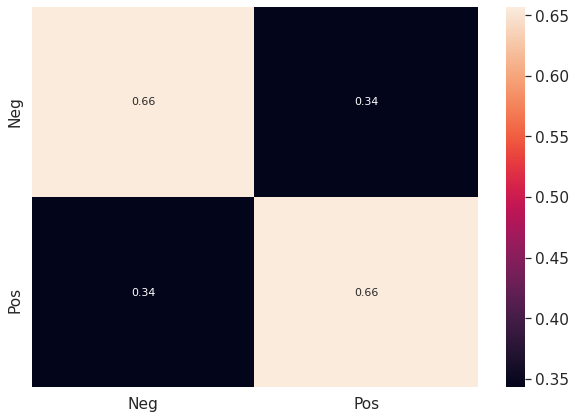

In [19]:
#predictions = code here
labelList=["Neg","Pos"]
predictions = model3.predict(test_data)

pred=[]
for i in predictions:
    pred.append(np.argmax(i))
predictions=pred

from sklearn.metrics import confusion_matrix

test_Y_max=np.argmax(test_Labels, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()

In [20]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = labelList))

Classification Report
               precision    recall  f1-score   support

         Neg       0.66      0.66      0.66      2265
         Pos       0.65      0.66      0.66      2235

    accuracy                           0.66      4500
   macro avg       0.66      0.66      0.66      4500
weighted avg       0.66      0.66      0.66      4500



#**LSTM**

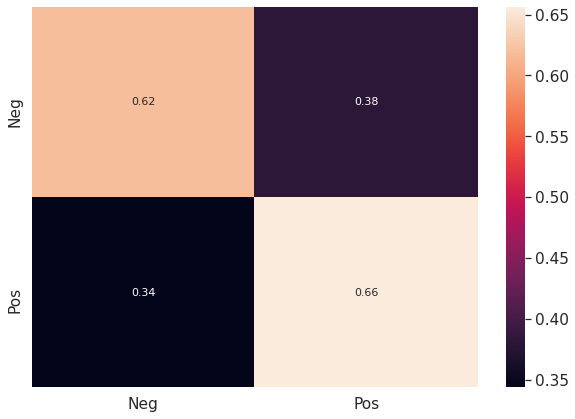

In [21]:
#predictions = code here
labelList=["Neg","Pos"]
predictions = model4.predict(test_data)

pred=[]
for i in predictions:
    pred.append(np.argmax(i))
predictions=pred

from sklearn.metrics import confusion_matrix

test_Y_max=np.argmax(test_Labels, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()


In [22]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = labelList))

Classification Report
               precision    recall  f1-score   support

         Neg       0.65      0.62      0.63      2265
         Pos       0.63      0.66      0.64      2235

    accuracy                           0.64      4500
   macro avg       0.64      0.64      0.64      4500
weighted avg       0.64      0.64      0.64      4500



# We hope all of you are working on your projects and <a href="https://ibb.co/dcpf4vS"> Kudos for completing the assingnment</a>